In [66]:
import pandas as pd

In [67]:
seci = pd.read_csv('../outputs/complexity_table2020-2021.csv',sep=';')

In [68]:
language_to_seci=dict(seci.groupby(['language'])['pci'].first())

In [69]:
gpt = pd.read_csv('../data/gpt_effect_estimates.csv',index_col=0)

In [70]:
map_names = {
    'vbscript':'VBScript',
    'objective-c':'Objective-C',
    'actionscript':'ActionScript',
    'gdb':'GDB',
    'tsql':'TSQL',
    'matlab':'MATLAB',
    'vb.net':'Visual Basic .NET',
    'php':'PHP',
    'coffeescript':'CoffeeScript',
    'asp.net':'ASP.NET',
    'qml':'QML',
    'vba':'VBA',
    'xslt':'XSLT',
    'applescript':'AppleScript',
    'cmake':'CMake',
    'vue.js':'Vue',
    'html':'HTML',
    'css':'CSS',
    'javascript':'JavaScript',
    'jupyter-notebook':'Jupyter Notebook',
    'powershell':'PowerShell',
    'typescript':'TypeScript'  
}

In [71]:
clean = {}
for x in gpt.index:
    if x.capitalize() in language_to_seci:
        clean[x]=x.capitalize()
    elif x in map_names:
        clean[x]=map_names[x]
    else:
        print(x)
  

delphi
coldfusion
arduino
hive
click
cucumber
max
gradle
sas
sed
io
nginx
sql
plsql


In [72]:
gpt.index=gpt.index.map(lambda x: clean.get(x,'missing'))
gpt_effect=dict(gpt[gpt.index!='missing'].estimate)

In [81]:
seci2=seci.groupby(['language'])['pci'].first().reset_index()
seci2['gpt_effect']=seci2['language'].map(gpt_effect)
seci2=seci2[~seci2['gpt_effect'].isnull()]

In [94]:
seci2['gpt_effect']=1-seci2['gpt_effect']

<AxesSubplot: xlabel='pci_binned', ylabel='gpt_effect'>

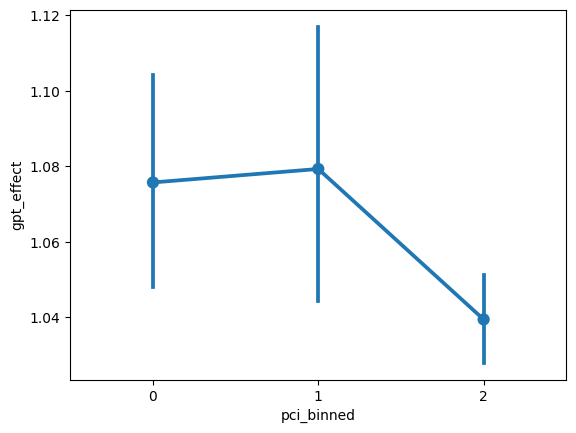

In [106]:
seci2['pci_binned'] = pd.cut(seci2['pci'], bins=3, labels=False)
sns.pointplot(x='pci_binned',y='gpt_effect',data=seci2)

R^2: -0.05
p:0.0020353132082907084
-0.40715235479229606


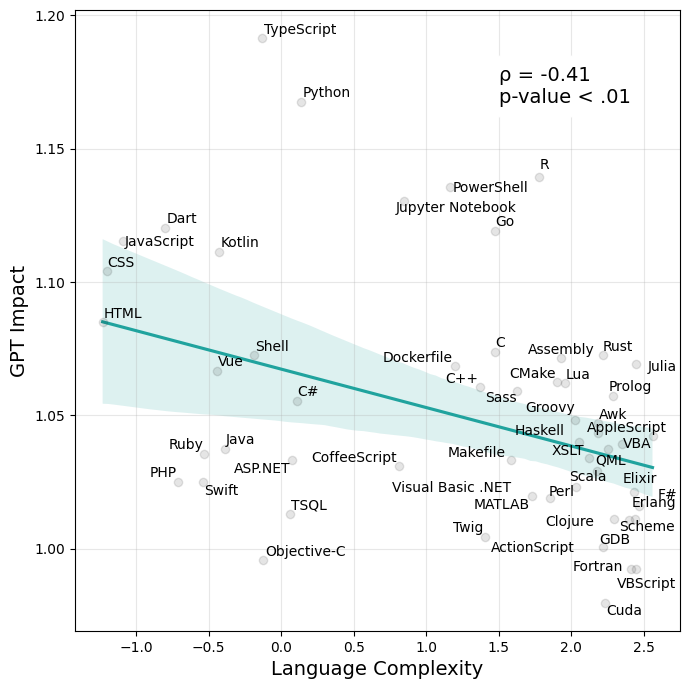

In [109]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from scipy import stats
import seaborn as sns
from adjustText import adjust_text

plt.figure(figsize=(7,7))

# Plot the scatter plot with error bars
plt.errorbar(seci2['pci'],seci2['gpt_effect'], yerr=0, fmt='o', capsize=0, label='Observations',
            color='black',alpha=.1)

# Fit a line to the data
model = LinearRegression()
model.fit(seci2[['pci']], seci2['gpt_effect'])

# Get the line's y values
seci2['y_fit'] = model.predict(seci2[['pci']])

# Plot the line
sns.regplot(x='pci', y='gpt_effect', data=seci2,robust=True,#lowess=True,
            ci=95, line_kws={'color': '#20A39E', 'label':'Fit'}, scatter=False)

#plt.plot(df2['log_nrepos_2021'], df2['y_fit'], color='red', label='Fit')

texts= []
for i, row in seci2.iterrows():
    texts.append(plt.annotate(row['language'], (row['pci'], row['gpt_effect']),size=10))
#    plt.annotate(row['index'], (row['log_nrepos_2021'], row['estimate']),size=8)
adjust_text(texts)

# Report R squared
r2 = r2_score(seci2['pci'], seci2['gpt_effect'])
print(f'R^2: {r2:.2f}')

pearson_corr, p_value = stats.pearsonr(seci2['pci'], seci2['gpt_effect'])
print('p:'+str(p_value))
print(pearson_corr)
plt.annotate(f'ρ = {pearson_corr:.2f}\np-value < .01',
             xy=(.7,.85), xycoords='axes fraction',size=14,
            bbox=dict(facecolor='white', edgecolor='white', boxstyle='round,pad=.5'))

plt.xlabel('Language Complexity',size=14)
plt.ylabel('GPT Impact',size=14)

plt.grid(alpha=.3)
# Show the plot
plt.tight_layout()
#plt.savefig('plots/tag_effects_vs_github_repos.pdf')
plt.show()


In [101]:
r2_score(seci2['pci'], seci2['gpt_effect'])

-0.05102099678377492